# Logistic Regression Classifier - Reviews of Restaurants, Gym and Automotive Categories


### Importing the neccessary packages

In [1]:
import pandas as pd
import numpy as np
from requests import get
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from gensim.models import word2vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1) Scraping Data for Three Categories

### Storing the URLs of three categories

In [0]:
restr_url = 'http://mlg.ucd.ie/modules/yalp/restaurants_list.html'
gym_url = 'http://mlg.ucd.ie/modules/yalp/gym_list.html'
automotive_url = 'http://mlg.ucd.ie/modules/yalp/automotive_list.html'

# This URL is found common in all the review sites and hence storing it in a variable for future usages.

url_p1 = 'http://mlg.ucd.ie/modules/yalp/'

### Defining a function scrape_data, which takes URL as input and returns reviews and corresponding rating labels. <br>Rating label is 0 for negative and 1 for positive rating.


In [0]:
#Function to scrap data using beautifulsoup and appending in list

def scrape_data(url):
    response = get(url)
    html_soup = BeautifulSoup(response.text,'html.parser')
    
    container= html_soup.find('div', id='all')
    review_list = []
    
    for element in container.find_all('h5'):
        url_p2=element.a.get('href')
        url_ratings = url_p1 + url_p2
        
        review_response=get(url_ratings)
        html_soup=BeautifulSoup(review_response.text,'html.parser')
        review_container=html_soup.find_all('div',class_='review')
    
        for element in review_container:
            time.sleep(.05)              # to avoid timeout error
            review_temp = []
            review_temp.append(element.find('p',class_='review-text').text)
            rating_count=int(element.find('p',class_='rating').img.get('alt')[0])
            if rating_count>=4:          # mark as positive review
                review_temp.append(1)
            else:                        # mark as negative review
                review_temp.append(0)
            
            review_list.append(review_temp)
                


    return review_list
    

### For the categories restaurant, Gym and Automotive scrape the data using the function scrape_data. <br>Create dataframes for each category using the scraped data.

In [0]:
# restaurant reviews
restr_review_data=scrape_data(restr_url)
restr_df=pd.DataFrame(restr_review_data,columns=['reviewText','label'])
# time.sleep(10)

# gym reviews
gym_review_data=scrape_data(gym_url)
gym_df=pd.DataFrame(gym_review_data,columns=['reviewText','label'])
# time.sleep(10)

# auto reviews
auto_review_data=scrape_data(automotive_url)
auto_df=pd.DataFrame(auto_review_data,columns=['reviewText','label'])

In [5]:
restr_df.head()

,reviewText,label
0,My husband and I had a rare afternoon off so w...,0
1,For years I thought this was only a wine store...,1
2,This place is so charming! I went with my husb...,1
3,We have been wanting to try this place for a c...,1
4,Decor looks ok but layout is too busy. Difficu...,0


In [6]:
gym_df.head()

,reviewText,label
0,If you're looking for boxing in the East Valle...,1
1,I was really excited to try a fun workout rout...,0
2,I was interested in taking a boxing bootcamp c...,0
3,I worked out at 1 on 1 boxing for a bout 6 mon...,1
4,This place literally KICKED my butt every. sin...,1


In [7]:
auto_df.head()

,reviewText,label
0,The man that was working tonight (8-12-17) was...,0
1,Chris is a very rude person. Gave me an attitu...,0
2,One of my favorite gas station to stop at. The...,1
3,Oh thank Heaven for Seven Eleven! I don't know...,0
4,Five stars because of the guy who works weekda...,1


## 2) Preprocessing, Building Predictive Models and Evaluating for each category

### a) Preprocessing Reviews

#### First we clean each review. For this we apply following steps:
1. Converting to lower case
2. Removing punctuations
3. Removing stop words
4. Stemming of words

In [0]:
#Cleaning Review Data using various nltk steps

def clean(list_of_reviews):
    clean_list_of_reviews=[]
    
    for sentence in list_of_reviews:
    # 1) making all words in lower case characters
        sentence = sentence.lower()

    # 2) remove punctuations for all reviews 
        tokenizer = nltk.RegexpTokenizer(r"\w+")
        sentence = tokenizer.tokenize(sentence)

    # 3) Removing stop words from reviews using english word set 
        stop_words = set(stopwords.words('english')) 
        sentence = [w for w in sentence if not w in stop_words] 

    # 4) stemming words using porter stemmer
        ps = PorterStemmer()
        sentence = [ps.stem(word) for word in sentence]

    # appending all reviews to clean_list_of_reviews
        clean_list_of_reviews.append(sentence)
    
    return clean_list_of_reviews

In [0]:
#calling function and converting to list
restr_review_clean=clean(restr_df.reviewText.tolist())
gym_review_clean=clean(gym_df.reviewText.tolist())
auto_review_clean=clean(auto_df.reviewText.tolist())


In [10]:
print("Before Cleaning: ",restr_df.reviewText.tolist()[2])
print("\nAfter cleaning: ",restr_review_clean[2])

Before Cleaning:  This place is so charming! I went with my husband and we both loved the simple clean decor and romantic lighting. The wine and food were both delicious. Our server was very attentive, friendly, and helpful. I also found it to be very affordable, with a range of wine prices and the option to enjoy some affordable appetizers if you don't want to spend money on a full meal. We will be back!

After cleaning:  ['place', 'charm', 'went', 'husband', 'love', 'simpl', 'clean', 'decor', 'romant', 'light', 'wine', 'food', 'delici', 'server', 'attent', 'friendli', 'help', 'also', 'found', 'afford', 'rang', 'wine', 'price', 'option', 'enjoy', 'afford', 'appet', 'want', 'spend', 'money', 'full', 'meal', 'back']


#### Next, we use Gensim's Word2Vec implementation to convert a review to a fixed length Vector

In [0]:
#hyperparameters for Word2Vec

num_features = 300              
min_word_count = 1                   
num_workers = 4
context = 10  #takes neighboring 10 words in the review into account to form a vector for each word

In [0]:
#function to vectorise sentences 
def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w]) # get vector for each word in the review and add all
            numw+=1
        except:
            pass
    return np.asarray(sent_vec) / numw # return mean of word vectors of each review

def vector_iterator(list_of_reviews):
    #Using gensim word2vec on a given text corpus
    model = word2vec.Word2Vec(list_of_reviews, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)
    
    vector_list=[]
    for sentence in list_of_reviews:
        vector_list.append(sent_vectorizer(sentence, model)) # calling sentence vectoriser for each review
    return vector_list

In [13]:
#vectorising features using vector iterator function
restr_df_feature=pd.DataFrame(vector_iterator(restr_review_clean))
gym_df_feature=pd.DataFrame(vector_iterator(gym_review_clean))
auto_df_feature=pd.DataFrame(vector_iterator(auto_review_clean))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [14]:
restr_df_feature.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.280227,-0.099522,-0.182381,-0.129539,0.117660,0.476186,-0.049913,0.048378,-0.121966,0.154092,0.086722,-0.073226,0.139543,0.450228,-0.225769,-0.407631,0.435657,0.137057,-0.061791,0.479153,-0.111667,-0.544155,-0.007401,-0.753022,-0.220534,0.220685,0.200331,0.567741,-0.282803,0.392609,-0.013766,-0.434460,0.070884,0.369074,0.258372,0.216954,0.050961,0.151224,-0.281124,0.039595,...,0.609023,0.056053,-0.149225,0.099142,-0.228056,0.054792,-0.000504,0.012555,-0.041403,0.082366,0.102889,0.065462,0.039355,-0.128038,-0.070324,0.407765,0.173147,-0.010627,0.844051,-0.044750,0.068320,-0.051550,0.324249,-0.129648,0.087758,-0.211863,-0.340216,0.254021,0.018305,-0.010609,-0.189667,-0.117322,0.005639,0.188049,0.142092,-0.050184,-0.167999,-0.000036,-0.244121,-0.133455
1,0.244737,-0.082689,-0.154638,-0.107944,0.100475,0.406429,-0.039545,0.044205,-0.106782,0.125683,0.077675,-0.064440,0.123675,0.381981,-0.195485,-0.343779,0.379178,0.119782,-0.058029,0.415137,-0.095829,-0.468664,-0.008197,-0.640242,-0.191143,0.189358,0.174810,0.493768,-0.239390,0.341450,-0.016149,-0.378308,0.055894,0.307800,0.218216,0.184125,0.048849,0.129457,-0.239519,0.033263,...,0.522772,0.042330,-0.129659,0.085535,-0.195200,0.041846,0.001287,0.010954,-0.039938,0.060049,0.094434,0.057354,0.030486,-0.109120,-0.057638,0.352169,0.148669,-0.009571,0.725769,-0.039094,0.054494,-0.045057,0.282517,-0.117986,0.072658,-0.181355,-0.287846,0.214551,0.012607,-0.006771,-0.165797,-0.103357,0.009559,0.157899,0.128497,-0.037639,-0.141653,0.000251,-0.207810,-0.113276
2,0.273785,-0.092351,-0.173427,-0.118179,0.114335,0.456879,-0.045079,0.048075,-0.123054,0.145184,0.087935,-0.070643,0.139011,0.430851,-0.218186,-0.385683,0.427385,0.135432,-0.063656,0.466161,-0.103894,-0.525770,-0.010706,-0.715111,-0.215909,0.212292,0.194818,0.554988,-0.267101,0.380095,-0.017910,-0.424003,0.062847,0.347401,0.245673,0.207519,0.057364,0.145161,-0.267579,0.037743,...,0.587966,0.047959,-0.143236,0.096080,-0.220454,0.045700,0.000888,0.013183,-0.045545,0.066319,0.104708,0.066168,0.034449,-0.121793,-0.063972,0.393749,0.165947,-0.008970,0.813556,-0.043250,0.061608,-0.049890,0.320331,-0.134415,0.079747,-0.202424,-0.324709,0.242337,0.015008,-0.010147,-0.184627,-0.113430,0.010671,0.177402,0.146758,-0.043016,-0.160196,0.000822,-0.233932,-0.129358


#### Therefore, each text review gets converted to 300 length numerical vector

### b) Building a Predictive Model


#### Define a function train_model() to try out different classifiers

In [0]:
def train_model(x,y):
#     classifier = RandomForestClassifier(n_estimators=100) #gives lesser accuracy
    classifier=LogisticRegression(random_state=0)
    classifier.fit(x,y)
    return classifier;

#### Train-test split the reviews for Model Validation

In [0]:
# We define the test ratio as 0.20 using sckit-learn train test spilt. Then we train the model using the train_model function.

test_ratio=.2

#sckit-learn train test split
restr_train_feature, restr_test_feature, restr_train_label, restr_test_label = train_test_split(restr_df_feature, restr_df.iloc[:,1], test_size=test_ratio, random_state=42)
gym_train_feature, gym_test_feature, gym_train_label, gym_test_label = train_test_split(gym_df_feature, gym_df.iloc[:,1], test_size=test_ratio, random_state=42)
auto_train_feature, auto_test_feature, auto_train_label, auto_test_label = train_test_split(auto_df_feature, auto_df.iloc[:,1], test_size=test_ratio, random_state=42)


#### Training the Models

In [0]:
restr_model_1 = train_model(restr_train_feature, restr_train_label)
gym_model_1 = train_model(gym_train_feature, gym_train_label)
auto_model_1 = train_model(auto_train_feature, auto_train_label)


### c) Evaluation and Explanation of Results

### Restaurant Reviews

Analysis of Restaurant Reviews Model
-----------------------------------------------------
Model validated on:  400  reviews
--------------------------------------------------------
Baseline, i.e. the ratio of actual positive to total reviews: 0.585
--------------------------------------------------------
Model Accuracy: 0.6875
Model F1-Score: 0.7714808043875686
--------------------------------------------------------
Confusion matrix:
[[ 64 102]
 [ 23 211]]

After Normalization for class imbalance:


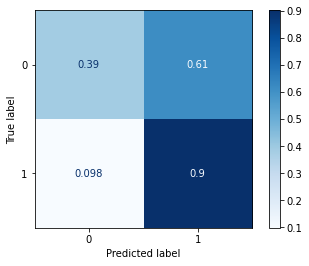

--------------------------------------------------------
Classification report


              precision    recall  f1-score   support

           0       0.74      0.39      0.51       166
           1       0.67      0.90      0.77       234

    accuracy                           0.69       400
   macro avg       0.70      0.64      0.64       400
weighted avg       0.70      0.69      0.66       400



In [18]:
# Test and evaluate the performance of restaurant data

print("Analysis of Restaurant Reviews Model")
print('-----------------------------------------------------')
print("Model validated on: ",len(restr_test_label)," reviews")
print("--------------------------------------------------------")
print('Baseline, i.e. the ratio of actual positive to total reviews:',restr_test_label.sum()/restr_test_label.count())
print("--------------------------------------------------------")

restr_predict = restr_model_1.predict(restr_test_feature) 
print("Model Accuracy:",accuracy_score(restr_test_label, restr_predict))
print("Model F1-Score:",f1_score(restr_test_label, restr_predict))
print("--------------------------------------------------------")
print("Confusion matrix:")
print(confusion_matrix(restr_test_label, restr_predict))
print("\nAfter Normalization for class imbalance:")
plot_confusion_matrix(restr_model_1, restr_test_feature, restr_test_label, cmap=plt.cm.Blues,normalize='true')
plt.show()
print("--------------------------------------------------------")
print("Classification report")
print('\n')
print(classification_report(restr_test_label, restr_predict))
    

### Gym Reviews

Analysis of Gym Reviews Model
-----------------------------------------------------
Model validated on:  400  reviews
--------------------------------------------------------
Baseline, i.e. the ratio of actual positive to total reviews: 0.675
--------------------------------------------------------
Model Accuracy: 0.82
Model F1-Score: 0.8723404255319148
--------------------------------------------------------
Confusion matrix:
[[ 82  48]
 [ 24 246]]

After Normalization for class imbalance:


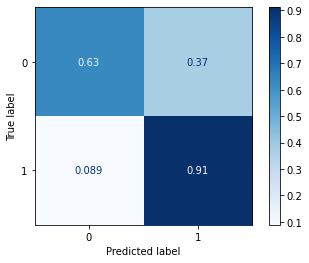

--------------------------------------------------------
Classification report


              precision    recall  f1-score   support

           0       0.77      0.63      0.69       130
           1       0.84      0.91      0.87       270

    accuracy                           0.82       400
   macro avg       0.81      0.77      0.78       400
weighted avg       0.82      0.82      0.81       400



In [19]:
# Test and evaluate the performance of Gym data

print("Analysis of Gym Reviews Model")
print('-----------------------------------------------------')
print("Model validated on: ",len(gym_test_label)," reviews")
print("--------------------------------------------------------")
print('Baseline, i.e. the ratio of actual positive to total reviews:',gym_test_label.sum()/gym_test_label.count())
print("--------------------------------------------------------")

gym_predict = gym_model_1.predict(gym_test_feature) 
print("Model Accuracy:",accuracy_score(gym_test_label, gym_predict))
print("Model F1-Score:",f1_score(gym_test_label, gym_predict))
print("--------------------------------------------------------")
print("Confusion matrix:")
print(confusion_matrix(gym_test_label, gym_predict))
print("\nAfter Normalization for class imbalance:")
plot_confusion_matrix(gym_model_1, gym_test_feature, gym_test_label, cmap=plt.cm.Blues,normalize='true')
plt.show()
print("--------------------------------------------------------")
print("Classification report")
print('\n')
print(classification_report(gym_test_label, gym_predict))
    


### Auto Reviews

Analysis of Auto Reviews Model
-----------------------------------------------------
Model validated on:  400  reviews
--------------------------------------------------------
Baseline, i.e. the ratio of actual positive to total reviews: 0.6275
--------------------------------------------------------
Model Accuracy: 0.7275
Model F1-Score: 0.7962616822429905
--------------------------------------------------------
Confusion matrix:
[[ 78  71]
 [ 38 213]]

After Normalization for class imbalance:


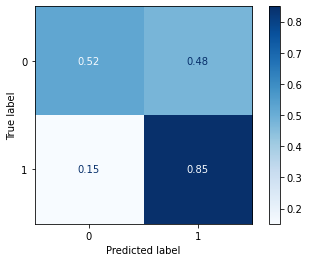

--------------------------------------------------------
Classification report


              precision    recall  f1-score   support

           0       0.67      0.52      0.59       149
           1       0.75      0.85      0.80       251

    accuracy                           0.73       400
   macro avg       0.71      0.69      0.69       400
weighted avg       0.72      0.73      0.72       400



In [20]:
# Test and evaluate the performance of Auto data

print("Analysis of Auto Reviews Model")
print('-----------------------------------------------------')
print("Model validated on: ",len(auto_test_label)," reviews")
print("--------------------------------------------------------")
print('Baseline, i.e. the ratio of actual positive to total reviews:',auto_test_label.sum()/auto_test_label.count())
print("--------------------------------------------------------")

auto_predict = auto_model_1.predict(auto_test_feature) 
print("Model Accuracy:",accuracy_score(auto_test_label, auto_predict))
print("Model F1-Score:",f1_score(auto_test_label, auto_predict))
print("--------------------------------------------------------")
print("Confusion matrix:")
print(confusion_matrix(auto_test_label, auto_predict))
print("\nAfter Normalization for class imbalance:")
plot_confusion_matrix(auto_model_1, auto_test_feature, auto_test_label, cmap=plt.cm.Blues,normalize='true')
plt.show()
print("--------------------------------------------------------")
print("Classification report")
print('\n')
print(classification_report(auto_test_label, auto_predict))
    


Restaurant labels class distribution


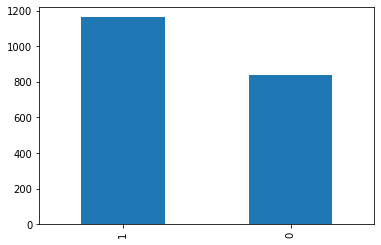

Gym labels class distribution


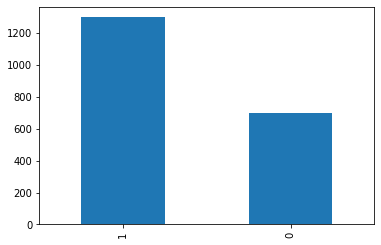

Auto labels class distribution


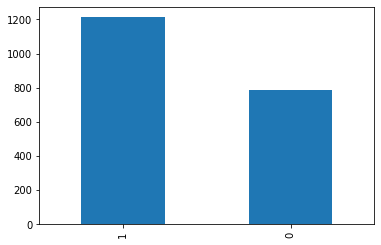

In [21]:
# Actual distribution of Class Labels

restr_df.label.value_counts().plot(kind='bar')
print("Restaurant labels class distribution")
plt.show()
gym_df.label.value_counts().plot(kind='bar')
print("Gym labels class distribution")
plt.show()
print("Auto labels class distribution")
auto_df.label.value_counts().plot(kind='bar')
plt.show()

## SUMMARY <br>

###  As can be seen in the above charts, there is a slight class imbalance in the reviews; we have more positive reviews than negative reviews. <br><br> Approximately, 60% of the reviews in each category are Positive. What this means is that if we randomly predict a class label without using any model, we will still have an approximate accuracy of 60%. <br><br>Since the classes are imbalanced because we have more positive revies than negative reviews, we should look at f1 score rather than only accuracy. <br>To measure Recall and Precision at the same time, F1-score helps giving a score using Harmonic Mean in place of Arithmetic Mean.<br><br>An f1-score of 1 is considered perfect. As such, approximately our f1-scores of .78, .87 and 0.80 for Restaurant, Gym and Auto data respectively,  are better than random guessing.<br><br><br>Our models predict accuracies (70%, 81.5% and 73.5%) higher than 60% in each category, therefore, the prediction accuracy is improved in all three categories.<br><br><br>

## 3) Evaluating Model Performance on Reviews of Other Categories

### a) Training on Restaurant data and Evaluating on Gym and Automotive data

In [0]:
#training on all Restaurant data
restr_model_2 = train_model(restr_df_feature, restr_df.iloc[:,1])

In [23]:
print("Evaluation of Restaurant Classifier on Gym data")
print("-------------------------------------------------------------------")
restr_model_gym_pred = restr_model_2.predict(gym_df_feature)

print("Accuracy: ",accuracy_score(gym_df.iloc[:,1], restr_model_gym_pred))
print("F1-score: ",f1_score(gym_df.iloc[:,1], restr_model_gym_pred))
# print('\n')
print("-------------------------------------------------------------------------")
print("Confusion matrix:")
print(confusion_matrix(gym_df.iloc[:,1], restr_model_gym_pred))
print('\n')
print("Classification Report:")
print("------------------------------------------------------------------------------")
print(classification_report(gym_df.iloc[:,1], restr_model_gym_pred))


Evaluation of Restaurant Classifier on Gym data
-------------------------------------------------------------------
Accuracy:  0.6995
F1-score:  0.8116577875274208
-------------------------------------------------------------------------
Confusion matrix:
[[ 104  597]
 [   4 1295]]


Classification Report:
------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.15      0.26       701
           1       0.68      1.00      0.81      1299

    accuracy                           0.70      2000
   macro avg       0.82      0.57      0.53      2000
weighted avg       0.78      0.70      0.62      2000



In [24]:
print("Evaluation of Restaurant Classifier on Auto data")
print("-------------------------------------------------------------------")
restr_model_auto_pred = restr_model_2.predict(auto_df_feature)

print("Accuracy:",accuracy_score(auto_df.iloc[:,1], restr_model_auto_pred))
print("F1-score:",f1_score(auto_df.iloc[:,1], restr_model_auto_pred))
print("-------------------------------------------------------------------")
print("Confusion matrix:")
print(confusion_matrix(auto_df.iloc[:,1], restr_model_auto_pred))
print('\n')
print("Classification Report:")
print("-------------------------------------------------------------------------------------")
print(classification_report(auto_df.iloc[:,1], restr_model_auto_pred))
# print('\n')

Evaluation of Restaurant Classifier on Auto data
-------------------------------------------------------------------
Accuracy: 0.394
F1-score: 0.0
-------------------------------------------------------------------
Confusion matrix:
[[ 788    0]
 [1212    0]]


Classification Report:
-------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.39      1.00      0.57       788
           1       0.00      0.00      0.00      1212

    accuracy                           0.39      2000
   macro avg       0.20      0.50      0.28      2000
weighted avg       0.16      0.39      0.22      2000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### b) Training on Gym data and evaluating on Restaurant and Automotive data

In [0]:
gym_model_2 = train_model(gym_df_feature, gym_df.iloc[:,1])

In [26]:
print("Evaluation of Gym Classifier on Restuarant data")
print("-------------------------------------------------------------------")
gym_model_restr_pred = gym_model_2.predict(restr_df_feature)

print("Accuracy:",accuracy_score(restr_df.iloc[:,1], gym_model_restr_pred))
print("F1-score:",f1_score(restr_df.iloc[:,1], gym_model_restr_pred))
# print('\n')
print("-------------------------------------------------------------------------")
print("Confusion matrix:")
print(confusion_matrix(restr_df.iloc[:,1], gym_model_restr_pred))
print('\n')
print("Classification Report:")
print("------------------------------------------------------------------------------")
print(classification_report(restr_df.iloc[:,1], gym_model_restr_pred))
# print('\n')

Evaluation of Gym Classifier on Restuarant data
-------------------------------------------------------------------
Accuracy: 0.419
F1-score: 0.0
-------------------------------------------------------------------------
Confusion matrix:
[[ 838    0]
 [1162    0]]


Classification Report:
------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.42      1.00      0.59       838
           1       0.00      0.00      0.00      1162

    accuracy                           0.42      2000
   macro avg       0.21      0.50      0.30      2000
weighted avg       0.18      0.42      0.25      2000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
print("Evaluation of Gym Classifier on Auto data")
print("-------------------------------------------------------------------")
gym_model_auto_pred = gym_model_2.predict(auto_df_feature)

print("Accuracy:",accuracy_score(auto_df.iloc[:,1], gym_model_auto_pred))
print("F1-score:",f1_score(auto_df.iloc[:,1], gym_model_auto_pred))
print("-------------------------------------------------------------------------")
# print('\n')
print("Confusion matrix:")
print(confusion_matrix(auto_df.iloc[:,1], gym_model_auto_pred))
print('\n')
print("Classification Report:")
print("------------------------------------------------------------------------------")
print(classification_report(auto_df.iloc[:,1], gym_model_auto_pred))
# print('\n')

Evaluation of Gym Classifier on Auto data
-------------------------------------------------------------------
Accuracy: 0.394
F1-score: 0.0
-------------------------------------------------------------------------
Confusion matrix:
[[ 788    0]
 [1212    0]]


Classification Report:
------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.39      1.00      0.57       788
           1       0.00      0.00      0.00      1212

    accuracy                           0.39      2000
   macro avg       0.20      0.50      0.28      2000
weighted avg       0.16      0.39      0.22      2000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### c) Training on Automotive data and evaluating on Restaurant and Gym data

In [0]:
auto_model_2 = train_model(auto_df_feature, auto_df.iloc[:,1])

In [29]:
print("Evaluation of Auto Classifier on Restaurant data")
print("-------------------------------------------------------------------")
auto_model_restr_pred = auto_model_2.predict(restr_df_feature)

print("Accuracy:",accuracy_score(restr_df.iloc[:,1], auto_model_restr_pred))
print("F1-score:",f1_score(restr_df.iloc[:,1], auto_model_restr_pred))
# print('\n')
print("--------------------------------------------------------------------------------")
print("Confusion matrix:")
print(confusion_matrix(restr_df.iloc[:,1], auto_model_restr_pred))
print('\n')
print("Classification Report:")
print("-------------------------------------------------------------------------------------")
print(classification_report(restr_df.iloc[:,1], auto_model_restr_pred))
print('\n')

Evaluation of Auto Classifier on Restaurant data
-------------------------------------------------------------------
Accuracy: 0.419
F1-score: 0.0
--------------------------------------------------------------------------------
Confusion matrix:
[[ 838    0]
 [1162    0]]


Classification Report:
-------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.42      1.00      0.59       838
           1       0.00      0.00      0.00      1162

    accuracy                           0.42      2000
   macro avg       0.21      0.50      0.30      2000
weighted avg       0.18      0.42      0.25      2000





/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
print("Evaluation of Auto Classifier on Gym data")
print("-------------------------------------------------------------------")
auto_model_gym_pred = auto_model_2.predict(gym_df_feature)

print("Accuracy::",accuracy_score(gym_df.iloc[:,1], auto_model_gym_pred))
print("F1-score:",f1_score(gym_df.iloc[:,1], auto_model_gym_pred))
# print('\n')
print("--------------------------------------------------------------------------------")
print("Confusion matrix:")
print(confusion_matrix(gym_df.iloc[:,1], auto_model_gym_pred))
print('\n')
print("Classification Report:")
print("------------------------------------------------------------------------------")
print(classification_report(gym_df.iloc[:,1], auto_model_gym_pred))
# print('\n')

Evaluation of Auto Classifier on Gym data
-------------------------------------------------------------------
Accuracy:: 0.8075
F1-score: 0.8547717842323651
--------------------------------------------------------------------------------
Confusion matrix:
[[ 482  219]
 [ 166 1133]]


Classification Report:
------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       701
           1       0.84      0.87      0.85      1299

    accuracy                           0.81      2000
   macro avg       0.79      0.78      0.78      2000
weighted avg       0.81      0.81      0.81      2000



## Summary
### While we get accuracies which are better than random guessing in the individual models in part (2) (see diagonal of the table below), this is not the case when using reviews from other categories in part (3) <br>Approximate accuracies:
<table><thead><tr><th>Model Trained On<br>Validated On</th><th>Restaurant</th><th>Gym</th><th>Auto</th></tr></thead><tbody><tr><td>Restaurant</td><td>70%</td><td>41.9%</td><td>57.9%</td></tr><tr><td>Gym</td><td>35.9%</td><td>81.5%</td><td>65.5%</td></tr><tr><td>Auto</td><td>39.4%</td><td>39.4%</td><td>73.5</td></tr></tbody></table>


### This is possibly because across categories, the reviews and words used in the reviews are highly different. <br>However, it is interesting to note that with Auto Model, we get good accuracy and F1-score on both Restaurant data and Gym data.<br><br>Nevertheless, a more generalised model would help in improving cross-category classification accuracy. <br>However, it is likely that such adjustment would cause model performance to fall within the category.